In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, use_bn = False):
        super().__init__()
        self.use_bn = use_bn
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(in_channels)    
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU() # maybe not be required

    def forward(self, x):
        residual = x
        out = x
        if self.use_bn:
            out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += residual
        return out

class ResidualPipeline(nn.Module):
    def __init__(self, in_channels, n_units, use_bn = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1, bias=True)
        layers = []
        for i in range(n_units):
            layers.append(ResidualUnit(64, use_bn))
        self.resnet_stack = nn.Sequential(*layers)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet_stack(x)
        x = self.relu(x) # not there in original paper
        x = self.conv2(x)
        return x
    
class STResnetNoExt(nn.Module):
    def __init__(self, c_channel, p_channel, t_channel, n_residual_units, map_dim, use_bn = False):
        super().__init__()
        self.c_pipe = ResidualPipeline(c_channel, n_residual_units, use_bn)
        self.p_pipe = ResidualPipeline(p_channel, n_residual_units, use_bn)
        self.t_pipe = ResidualPipeline(t_channel, n_residual_units, use_bn)
        # 1 dimension for batch processing, this class cannot process unbatched data
        self.w_c = nn.Parameter(torch.randn(1, *map_dim))
        self.w_p = nn.Parameter(torch.randn(1, *map_dim))
        self.w_t = nn.Parameter(torch.randn(1, *map_dim))
        self.tanh = nn.Tanh()
        
    def forward(self, x_c, x_p, x_t):
        y_c = self.c_pipe(x_c)
        y_p = self.p_pipe(x_p)
        y_t = self.t_pipe(x_t)
        # Fusion: Eliment wise product (Hadamard Product)
        y = self.w_c*y_c + self.w_p*y_p + self.w_t*y_t
        y = self.tanh(y)
        return y

In [3]:
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from BikeNYC import BikeNYCDataset
n_closeness = 4
n_period = 1
n_trend = 1
flow_ch = 2 # Inflow and Outflow
n_residual_units = 4
map_dim = (flow_ch, 21,12) # Specific to dataset
bikenyc_dataset_train = BikeNYCDataset('./Datasets/BikeNYC/',n_closeness,n_period,n_trend,0.8,True)
bikenyc_dataset_test = BikeNYCDataset('./Datasets/BikeNYC/',n_closeness,n_period,n_trend,0.8,False)

min: 0.0 max: 737.0
torch.Size([3379, 8, 21, 12]) torch.Size([3379, 2, 21, 12]) torch.Size([3379, 2, 21, 12])
min: 0.0 max: 737.0
torch.Size([845, 8, 21, 12]) torch.Size([845, 2, 21, 12]) torch.Size([845, 2, 21, 12])


In [4]:
from tqdm import tqdm
mmn = bikenyc_dataset_train.mmn

def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss = 0.0
    model.train()
    for x_c, x_p, x_t, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x_c, x_p, x_t)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss = 0.0
    model.eval()
    for x_c, x_p, x_t, y in dataloader:
        output = model(x_c, x_p, x_t)
        loss = loss_fn(output, y)
        valid_loss += loss.item()
    return valid_loss

In [5]:
import torch.optim as optim
batch_size = 32
num_epochs = 10

# train_size = int(0.9 * len(bikenyc_dataset_train))
# valid_size = len(bikenyc_dataset_train) - train_size
# train_idx, valid_idx = random_split(range(len(bikenyc_dataset_train)), [train_size, valid_size])
# train_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
# valid_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

# model = STResnetNoExt(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,map_dim,True).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_fun = nn.MSELoss(reduction = 'sum')

# history = {'train_loss': [], 'valid_loss': []}
# for epoch in range(num_epochs):
#     train_loss=train_epoch(model,train_loader,loss_fun,optimizer)/len(train_loader.sampler)
#     valid_loss=valid_epoch(model,valid_loader,loss_fun)/len(valid_loader.sampler)
#     print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
#     history['train_loss'].append(train_loss)
#     history['valid_loss'].append(valid_loss)

from sklearn.model_selection import KFold
splits = KFold(n_splits=10,shuffle=True)
foldperf={}
least_loss_yet = 2 # maximum loss we can expect, can be any large number
for fold, (train_idx,valid_idx) in enumerate(splits.split(np.arange(len(bikenyc_dataset_train)))):
    print('Fold {}'.format(fold + 1))
    train_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
    valid_loader = DataLoader(bikenyc_dataset_train, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

    model = STResnetNoExt(n_closeness*flow_ch,n_period*flow_ch,n_trend*flow_ch,n_residual_units,map_dim,True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fun = nn.MSELoss(reduction = 'sum')

    history = {'train_loss': [], 'valid_loss': []}
    for epoch in range(num_epochs):
        train_loss=train_epoch(model,train_loader,loss_fun,optimizer)/len(train_loader.sampler)
        valid_loss=valid_epoch(model,valid_loader,loss_fun)/len(valid_loader.sampler)
        print("Epoch:{}/{} | Training Loss: {} | Validation Loss: {}".format(epoch + 1, num_epochs, train_loss, valid_loss))
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        if valid_loss < least_loss_yet:
            print('Saving a better model!')
            torch.save(model,'Checkpoints/BikeNYC/k_fold_stresnet.pt')
            least_loss_yet = valid_loss
        
    foldperf['fold{}'.format(fold+1)] = history     

Fold 1


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 12.36it/s]


Epoch:1/10 | Training Loss: 44.59544027161339 | Validation Loss: 1.4695974948138175
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.86it/s]


Epoch:2/10 | Training Loss: 0.8336429462468926 | Validation Loss: 0.721046808908677
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.61it/s]


Epoch:3/10 | Training Loss: 0.5509316498160715 | Validation Loss: 0.5504345555277266
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.86it/s]


Epoch:4/10 | Training Loss: 0.43416142514644973 | Validation Loss: 0.44767866755378316
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.96it/s]


Epoch:5/10 | Training Loss: 0.36601155569035143 | Validation Loss: 0.38594717951215934
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.99it/s]


Epoch:6/10 | Training Loss: 0.31491815191238814 | Validation Loss: 0.38381426150982195
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.75it/s]


Epoch:7/10 | Training Loss: 0.28074064175575353 | Validation Loss: 0.31464635408841646
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.23it/s]


Epoch:8/10 | Training Loss: 0.2573760799654453 | Validation Loss: 0.33554083073632957


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.47it/s]


Epoch:9/10 | Training Loss: 0.23704923050884194 | Validation Loss: 0.29620457542013134
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.27it/s]


Epoch:10/10 | Training Loss: 0.23430526810270985 | Validation Loss: 0.398998331036088
Fold 2


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.08it/s]


Epoch:1/10 | Training Loss: 44.87056462857254 | Validation Loss: 1.0973785106952374


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.98it/s]


Epoch:2/10 | Training Loss: 0.8114537988513444 | Validation Loss: 0.7712473163943319


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.17it/s]


Epoch:3/10 | Training Loss: 0.515738235575241 | Validation Loss: 0.4744118064112917


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.36it/s]


Epoch:4/10 | Training Loss: 0.4198500363891825 | Validation Loss: 0.44254442925989274


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.43it/s]


Epoch:5/10 | Training Loss: 0.3640269072029944 | Validation Loss: 0.5027877706042408


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.29it/s]


Epoch:6/10 | Training Loss: 0.342450130538539 | Validation Loss: 0.3716313810743524


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.11it/s]


Epoch:7/10 | Training Loss: 0.29003300881628846 | Validation Loss: 0.3397210250944781


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.49it/s]


Epoch:8/10 | Training Loss: 0.26845654615423703 | Validation Loss: 0.29165639820888906
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.01it/s]


Epoch:9/10 | Training Loss: 0.23721125173121838 | Validation Loss: 0.29493333037788344


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.31it/s]


Epoch:10/10 | Training Loss: 0.24085686427125488 | Validation Loss: 0.2821447355507394
Saving a better model!
Fold 3


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.12it/s]


Epoch:1/10 | Training Loss: 45.54433476513289 | Validation Loss: 1.2254537040665305


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.86it/s]


Epoch:2/10 | Training Loss: 0.8285752732045789 | Validation Loss: 0.8027078780902208


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.91it/s]


Epoch:3/10 | Training Loss: 0.553905690276909 | Validation Loss: 0.519606926032072


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.95it/s]


Epoch:4/10 | Training Loss: 0.4226934583278833 | Validation Loss: 0.41912795664996083


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.03it/s]


Epoch:5/10 | Training Loss: 0.42790600458519584 | Validation Loss: 0.4136536248336882


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.82it/s]


Epoch:6/10 | Training Loss: 0.3370467367061695 | Validation Loss: 0.3628635265418058


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.80it/s]


Epoch:7/10 | Training Loss: 0.3045761351403497 | Validation Loss: 0.3648735743302565


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.45it/s]


Epoch:8/10 | Training Loss: 0.27741341816677306 | Validation Loss: 0.6549348196334387


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.83it/s]


Epoch:9/10 | Training Loss: 0.2849839865690938 | Validation Loss: 0.3601434089728361


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.10it/s]


Epoch:10/10 | Training Loss: 0.24478476022427428 | Validation Loss: 0.29670774866137983
Fold 4


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.81it/s]


Epoch:1/10 | Training Loss: 48.701094740591955 | Validation Loss: 5.483064911069249


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.07it/s]


Epoch:2/10 | Training Loss: 5.003353582719014 | Validation Loss: 4.745972627718773


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.20it/s]


Epoch:3/10 | Training Loss: 4.658672241661275 | Validation Loss: 4.67456916944515


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.34it/s]


Epoch:4/10 | Training Loss: 4.54488174133652 | Validation Loss: 4.584370404305543


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.62it/s]


Epoch:5/10 | Training Loss: 4.47770167212469 | Validation Loss: 4.458467246512689


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.90it/s]


Epoch:6/10 | Training Loss: 4.428417310084375 | Validation Loss: 4.416564670540172


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.33it/s]


Epoch:7/10 | Training Loss: 4.35289692525917 | Validation Loss: 4.339174123910757


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.21it/s]


Epoch:8/10 | Training Loss: 4.311580248860613 | Validation Loss: 4.3096159985784945


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.36it/s]


Epoch:9/10 | Training Loss: 4.290081473723402 | Validation Loss: 4.3224024575137525


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.30it/s]


Epoch:10/10 | Training Loss: 4.270823061917025 | Validation Loss: 4.306023885512493
Fold 5


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.89it/s]


Epoch:1/10 | Training Loss: 51.666935145796145 | Validation Loss: 13.507030735354451


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.28it/s]


Epoch:2/10 | Training Loss: 12.840898262909548 | Validation Loss: 12.98271757046852


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.86it/s]


Epoch:3/10 | Training Loss: 12.58309001383206 | Validation Loss: 12.547136972641804


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.04it/s]


Epoch:4/10 | Training Loss: 12.456448710227397 | Validation Loss: 12.564009536652875


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.64it/s]


Epoch:5/10 | Training Loss: 12.40970853487546 | Validation Loss: 12.527578049157498


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.62it/s]


Epoch:6/10 | Training Loss: 12.350198412678502 | Validation Loss: 12.376957729723326


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.50it/s]


Epoch:7/10 | Training Loss: 12.307437330984198 | Validation Loss: 12.378754926151073


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.03it/s]


Epoch:8/10 | Training Loss: 12.298298308583554 | Validation Loss: 12.557861734424117


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.93it/s]


Epoch:9/10 | Training Loss: 12.273826278616276 | Validation Loss: 12.34279573880709


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.83it/s]


Epoch:10/10 | Training Loss: 12.26215790933937 | Validation Loss: 12.283643372665496
Fold 6


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.05it/s]


Epoch:1/10 | Training Loss: 41.84917958397804 | Validation Loss: 1.5667381060899361


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.73it/s]


Epoch:2/10 | Training Loss: 0.7902553457839048 | Validation Loss: 0.7771916558756631


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.03it/s]


Epoch:3/10 | Training Loss: 0.5198863482875128 | Validation Loss: 0.7906517643900313


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.41it/s]


Epoch:4/10 | Training Loss: 0.4103440182630814 | Validation Loss: 0.4587458971689439


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.25it/s]


Epoch:5/10 | Training Loss: 0.34272561912001925 | Validation Loss: 0.4887414768602721


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.19it/s]


Epoch:6/10 | Training Loss: 0.3086542561821779 | Validation Loss: 0.46734953490940073


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.26it/s]


Epoch:7/10 | Training Loss: 0.2722749501755856 | Validation Loss: 0.33082241701656545


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.24it/s]


Epoch:8/10 | Training Loss: 0.2500845243255781 | Validation Loss: 0.31735194505319086


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.30it/s]


Epoch:9/10 | Training Loss: 0.22661687072583306 | Validation Loss: 2.089826256565794


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.74it/s]


Epoch:10/10 | Training Loss: 0.27251327238224793 | Validation Loss: 1.151557279056346
Fold 7


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 17.61it/s]


Epoch:1/10 | Training Loss: 46.266409510807236 | Validation Loss: 5.946432440943972


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.08it/s]


Epoch:2/10 | Training Loss: 5.0028071619891215 | Validation Loss: 4.697737676857491


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.58it/s]


Epoch:3/10 | Training Loss: 4.63758217853294 | Validation Loss: 4.611240770689834


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.28it/s]


Epoch:4/10 | Training Loss: 4.493616480452573 | Validation Loss: 4.4434355109401


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.90it/s]


Epoch:5/10 | Training Loss: 4.3902582071675 | Validation Loss: 4.363796301847379


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.15it/s]


Epoch:6/10 | Training Loss: 4.336307840181079 | Validation Loss: 4.342137105366182


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.55it/s]


Epoch:7/10 | Training Loss: 4.302290209889686 | Validation Loss: 4.286898234892174


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.59it/s]


Epoch:8/10 | Training Loss: 4.271524288198815 | Validation Loss: 4.368031902426093


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.98it/s]


Epoch:9/10 | Training Loss: 4.247451636556809 | Validation Loss: 4.283029319266595


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.27it/s]


Epoch:10/10 | Training Loss: 4.245416165809418 | Validation Loss: 4.234410957471859
Fold 8


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.66it/s]


Epoch:1/10 | Training Loss: 37.81139845065638 | Validation Loss: 1.2417386071921805


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.01it/s]


Epoch:2/10 | Training Loss: 0.868162475420981 | Validation Loss: 0.7049167988568368


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.45it/s]


Epoch:3/10 | Training Loss: 0.5796912250668546 | Validation Loss: 0.5233497393907175


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 17.98it/s]


Epoch:4/10 | Training Loss: 0.4639154421346276 | Validation Loss: 0.4668372566178


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 17.91it/s]


Epoch:5/10 | Training Loss: 0.3974098135220773 | Validation Loss: 0.43768173138770833


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.58it/s]


Epoch:6/10 | Training Loss: 0.36231444894150266 | Validation Loss: 0.4467356078018098


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 17.82it/s]


Epoch:7/10 | Training Loss: 0.32696677367571975 | Validation Loss: 0.34217574892664804


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.66it/s]


Epoch:8/10 | Training Loss: 0.2999021525310082 | Validation Loss: 0.3425594631736801


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.82it/s]


Epoch:9/10 | Training Loss: 0.2746117420296103 | Validation Loss: 0.3127215430581358


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.64it/s]


Epoch:10/10 | Training Loss: 0.2601178207510359 | Validation Loss: 0.30644345142432217
Fold 9


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.56it/s]


Epoch:1/10 | Training Loss: 48.64528114954056 | Validation Loss: 1.4746885017530453


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.13it/s]


Epoch:2/10 | Training Loss: 0.8055822249503168 | Validation Loss: 1.348000977871686


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.95it/s]


Epoch:3/10 | Training Loss: 0.5153715659113003 | Validation Loss: 0.4976250857291137


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.94it/s]


Epoch:4/10 | Training Loss: 0.39792263790087967 | Validation Loss: 0.49900215758374455


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.57it/s]


Epoch:5/10 | Training Loss: 0.3425935468502007 | Validation Loss: 0.4067016240407729


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.25it/s]


Epoch:6/10 | Training Loss: 0.3112474214340738 | Validation Loss: 0.882562992840829


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.94it/s]


Epoch:7/10 | Training Loss: 0.28821226163586283 | Validation Loss: 0.3321331986308803


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 17.88it/s]


Epoch:8/10 | Training Loss: 0.25751981753653813 | Validation Loss: 0.3977038140833025


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.21it/s]


Epoch:9/10 | Training Loss: 0.24344767182722407 | Validation Loss: 0.27749111666481874
Saving a better model!


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.17it/s]


Epoch:10/10 | Training Loss: 0.230657023246333 | Validation Loss: 0.2818215556398651
Fold 10


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.98it/s]


Epoch:1/10 | Training Loss: 40.99726469049636 | Validation Loss: 1.5024132544633542


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.47it/s]


Epoch:2/10 | Training Loss: 0.8578409715987286 | Validation Loss: 0.7178486787247021


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.06it/s]


Epoch:3/10 | Training Loss: 0.5566892746069335 | Validation Loss: 0.5214959068185144


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.73it/s]


Epoch:4/10 | Training Loss: 0.43479661539657427 | Validation Loss: 0.7184836673453583


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 19.04it/s]


Epoch:5/10 | Training Loss: 0.3937004728390934 | Validation Loss: 0.4055925717339671


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.10it/s]


Epoch:6/10 | Training Loss: 0.3210660357133563 | Validation Loss: 1.3158128042249368


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.25it/s]


Epoch:7/10 | Training Loss: 0.29911599364584796 | Validation Loss: 0.3725254033368844


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.22it/s]


Epoch:8/10 | Training Loss: 0.2716531867968417 | Validation Loss: 0.30031733838316244


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.30it/s]


Epoch:9/10 | Training Loss: 0.2555646621949731 | Validation Loss: 0.3447334235782793


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 18.95it/s]


Epoch:10/10 | Training Loss: 0.23348983599119166 | Validation Loss: 0.4055712612163419


In [11]:
import math
test_loader = DataLoader(bikenyc_dataset_test, batch_size=batch_size)
test_loss = 0.0
model = torch.load('Checkpoints/BikeNYC/k_fold_stresnet.pt')
model.eval()
for x_c, x_p, x_t, y in test_loader:
    output = mmn.inverse_transform(model(x_c, x_p, x_t))
    loss = loss_fun(output, mmn.inverse_transform(y))
    test_loss += loss.item()
rmse_loss = math.sqrt(test_loss/len(test_loader.sampler))
print('Map Root Mean Square Loss: ', rmse_loss)
rmse_loss = math.sqrt(test_loss/(len(test_loader.sampler)*np.prod(map_dim)))
print('Grid Root Mean Square Loss: ', rmse_loss)

Map Root Mean Square Loss:  213.6592380576989
Grid Root Mean Square Loss:  9.517138884893823


In [8]:
flow_pred = np.zeros((len(bikenyc_dataset_test),*map_dim))
flow_org = np.zeros((len(bikenyc_dataset_test),*map_dim))
for i in range(len(bikenyc_dataset_test)):
    x_c, x_p, x_t, y = bikenyc_dataset_test[i]
    x_c = torch.unsqueeze(x_c, 0)
    x_p = torch.unsqueeze(x_p, 0)
    x_t = torch.unsqueeze(x_t, 0)    
    y_pred = model(x_c, x_p, x_t)
    flow_org[i,:,:,:] = mmn.inverse_transform(y).cpu().detach().numpy()[:,:,:]
    flow_pred[i,:,:,:] = mmn.inverse_transform(y_pred).cpu().detach().numpy()[:,:,:]

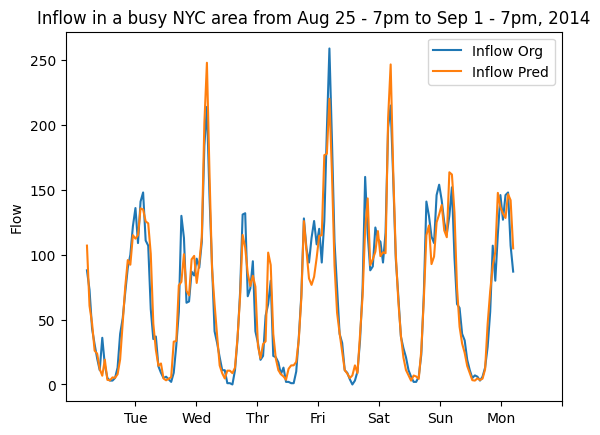

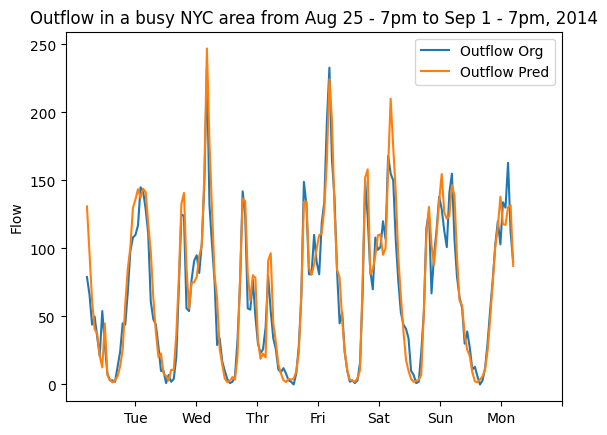

In [9]:
import matplotlib.pyplot as plt
x, y = 10, 3

fig = plt.figure()
in_flow_org = flow_org[24*7*0:24*7*1,0,x,y]
in_flow_pred = flow_pred[24*7*0:24*7*1,0,x,y]
t = np.linspace(1, 24*7*1, num=24*7*1)
plt.plot(t,in_flow_org,label='Inflow Org')
plt.plot(t,in_flow_pred,label='Inflow Pred')
plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Inflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure()
out_flow_org = flow_org[24*7*0:24*7*1,1,x,y]
out_flow_pred = flow_pred[24*7*0:24*7*1,1,x,y]
t = np.linspace(1, 24*7*1, num=24*7*1)
plt.plot(t,out_flow_org,label='Outflow Org')
plt.plot(t,out_flow_pred,label='Outflow Pred')
plt.xticks(np.linspace(1+19, 168+19, num=8),['Tue','Wed','Thr','Fri','Sat','Sun','Mon',''])
plt.title('Outflow in a busy NYC area from Aug 25 - 7pm to Sep 1 - 7pm, 2014')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()